# Using the saved trained CNN model to perform denoising and calculate the metrics

In [1]:
import os
import numpy as np
import tensorflow as tf
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from tensorflow.image import psnr, ssim
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model

In [2]:
# Load the saved model
model = tf.keras.models.load_model('Denoising_CNN_Model')

In [3]:
extract_folder = 'CroppedImages'


# List files to check the structure
file_list = os.listdir(extract_folder)
print("Sample of files:", file_list[:10])  # Print first 10 file names to check

def pair_images(file_list):
    paired_images = {}
    for file in file_list:
        parts = file.split('_')
        key = '_'.join(parts[:-1])  # Create a key by excluding the last part (mean/real)
        image_type = parts[-1].split('.')[0]  # Identify if it's 'mean' or 'real'

        if key not in paired_images:
            paired_images[key] = {}
        paired_images[key][image_type] = os.path.join(extract_folder, file)

    return paired_images

paired_images = pair_images(file_list)  # Make sure this function works correctly as discussed earlier

# Prepare a list of file paths for real and mean images
real_paths = []
mean_paths = []

for key, paths in paired_images.items():
    if 'real' in paths and 'mean' in paths:  # Check if both keys are present
        real_paths.append(paths['real'])
        mean_paths.append(paths['mean'])

Sample of files: ['Canon5D2_5_160_3200_chair_11_mean.JPG', 'Canon5D2_5_160_3200_chair_11_real.JPG', 'Canon5D2_5_160_3200_chair_14_mean.JPG', 'Canon5D2_5_160_3200_chair_14_real.JPG', 'Canon5D2_5_160_3200_chair_5_mean.JPG', 'Canon5D2_5_160_3200_chair_5_real.JPG', 'Canon5D2_5_160_3200_plug_11_mean.JPG', 'Canon5D2_5_160_3200_plug_11_real.JPG', 'Canon5D2_5_160_3200_plug_12_mean.JPG', 'Canon5D2_5_160_3200_plug_12_real.JPG']


In [4]:
def reconstruct_from_fourier(fourier_data):
    """
    Reconstruct the spatial domain image from its Fourier-transformed representation.

    Args:
        fourier_data (numpy.ndarray): Input array containing Fourier-transformed data,
            with the last dimension holding alternating real and imaginary parts
            for each channel (e.g., [real1, imag1, real2, imag2, ...]).

    Returns:
        numpy.ndarray: Reconstructed multi-channel image in the spatial domain, normalized to [0, 1].

    Raises:
        AssertionError: If the last dimension of fourier_data is not even.
    """
    # Ensure the channel dimension is even (must have pairs of real and imaginary components)
    assert fourier_data.shape[-1] % 2 == 0, "The channel dimension must be even."

    num_channels = fourier_data.shape[-1] // 2  # Calculate the number of channels
    reconstructed_images = []  # Initialize a list to hold reconstructed channel images

    for i in range(num_channels):
        # Extract real and imaginary parts for the current channel
        real_part = fourier_data[..., 2*i]
        imag_part = fourier_data[..., 2*i+1]
        
        # Combine real and imaginary parts into a complex number
        complex_image = real_part + 1j * imag_part
        
        # Inverse FFT to convert back to spatial domain
        spatial_image = ifft2(ifftshift(complex_image))
        
        # Convert to magnitude (intensity) by taking the absolute value
        spatial_image = np.abs(spatial_image)
        reconstructed_images.append(spatial_image)

    # Stack the single-channel images along the last axis to form a multi-channel spatial image
    reconstructed_image = np.stack(reconstructed_images, axis=-1)

    # Normalize the reconstructed image to be in the range [0, 1]
    reconstructed_image -= reconstructed_image.min()
    reconstructed_image /= reconstructed_image.max()

    return reconstructed_image

In [5]:
def load_and_preprocess_image(real_path, mean_path):
    """
    Load and preprocess noisy and clean images from given file paths, apply Fourier transform,
    and normalize the images.

    Args:
        real_path (str): File path to the noisy image.
        mean_path (str): File path to the clean (mean) image.

    Returns:
        tuple: Tuple containing arrays for the Fourier-transformed noisy and clean images.
    """
    # Load images with a target size and normalize pixel values
    noisy_img = load_img(real_path, target_size=(512, 512))
    clean_img = load_img(mean_path, target_size=(512, 512))

    # Convert images to numpy arrays and normalize
    noisy_array = img_to_array(noisy_img) / 255.0
    clean_array = img_to_array(clean_img) / 255.0

    # Apply Fourier transform to both noisy and clean images
    noisy_ft = apply_fourier_transform(noisy_array.astype('float32'))
    clean_ft = apply_fourier_transform(clean_array.astype('float32'))

    return noisy_ft, clean_ft

def apply_fourier_transform(image_array):
    """
    Apply the Fourier transform to each color channel of an RGB image and return the real and imaginary parts stacked along the channel axis.

    Args:
        image_array (numpy.ndarray): Input RGB image array.

    Returns:
        numpy.ndarray: Array with the real and imaginary parts of the Fourier transformed channels stacked.
    """
    # Initialize an array to hold the transformed data with twice as many channels
    transformed = np.zeros((*image_array.shape[:-1], image_array.shape[-1]*2), dtype=np.float32)
    
    for i in range(3):  # Assuming RGB channels
        channel_ft = np.fft.fftshift(np.fft.fft2(image_array[:, :, i]))
        transformed[:, :, 2*i] = channel_ft.real
        transformed[:, :, 2*i+1] = channel_ft.imag
    
    return transformed

In [6]:
def calculate_and_compare_images(real_paths, mean_paths, model, num_examples=5):
    """
    Evaluate a model by calculating PSNR and SSIM for a set of images.

    Args:
        real_paths (list): Paths to noisy images.
        mean_paths (list): Paths to corresponding ground truth clean images.
        model (tf.keras.Model): Trained model that predicts denoised images in the Fourier domain.
        num_examples (int): Number of examples to process.

    Returns:
        float: Average PSNR across processed examples.
        float: Average SSIM across processed examples.
        list: List of tuples containing clean, noisy, and reconstructed denoised images.
    """
    psnr_values = []
    ssim_values = []
    examples = []

    # Process up to num_examples images
    for i in range(min(num_examples, len(real_paths))):
        real_path, mean_path = real_paths[i], mean_paths[i]

        # Load and preprocess images
        noisy_img = load_img(real_path, target_size=(512, 512))
        clean_img = load_img(mean_path, target_size=(512, 512))
        noisy_array = img_to_array(noisy_img) / 255.0
        clean_array = img_to_array(clean_img) / 255.0

        # Load and preprocess images for Fourier domain processing
        noisy_ft, _ = load_and_preprocess_image(real_path, mean_path)

        # Simulate a batch of size 1 for prediction
        noisy_ft = np.expand_dims(noisy_ft, axis=0)

        # Predict the denoised Fourier domain image
        predicted_clean_ft = model.predict(noisy_ft)[0]

        # Reconstruct the denoised image from its Fourier transform
        reconstructed_denoised = reconstruct_from_fourier(predicted_clean_ft)

        # Store the clean, noisy, and reconstructed images for later visualization
        examples.append((clean_array, noisy_array, reconstructed_denoised))

        # Calculate PSNR and SSIM between the clean and reconstructed images
        clean_array_tensor = tf.convert_to_tensor(clean_array, dtype=tf.float32)
        reconstructed_denoised_tensor = tf.convert_to_tensor(reconstructed_denoised, dtype=tf.float32)
        current_psnr = tf.image.psnr(clean_array_tensor, reconstructed_denoised_tensor, max_val=1.0).numpy()
        current_ssim = tf.image.ssim(clean_array_tensor, reconstructed_denoised_tensor, max_val=1.0).numpy()

        psnr_values.append(current_psnr)
        ssim_values.append(current_ssim)

    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim, examples


# Calculating the average metric for all images (100) in dataset

In [7]:
average_psnr, average_ssim, image_examples = calculate_and_compare_images(real_paths, mean_paths, model, num_examples=100)  # Calculate for all 100 images in the dataset
print(f"Average PSNR: {average_psnr}")
print(f"Average SSIM: {average_ssim}")

1/1 [==============================] - 1s 754ms/step
Average PSNR: 24.663389205932617
Average SSIM: 0.9027183651924133


# Visualized first 5 image sets

In [8]:
def visualize_examples(examples, N):
    # Ensure we do not attempt to display more images than available
    N = min(N, len(examples))
    plt.figure(figsize=(15, N * 5))  # Adjust the figure size to fit all images appropriately

    for i in range(N):
        clean_img, noisy_img, denoised_img = examples[i]

        # Plotting the clean image
        plt.subplot(N, 3, 3 * i + 1)
        plt.imshow(clean_img)
        plt.title(f'Ground Truth Image {i+1}')
        plt.axis('off')

        # Plotting the noisy image
        plt.subplot(N, 3, 3 * i + 2)
        plt.imshow(noisy_img)
        plt.title(f'Noisy Image {i+1}')
        plt.axis('off')

        # Plotting the denoised image
        plt.subplot(N, 3, 3 * i + 3)
        plt.imshow(denoised_img)
        plt.title(f'Denoised Image {i+1} (CNN Model)')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


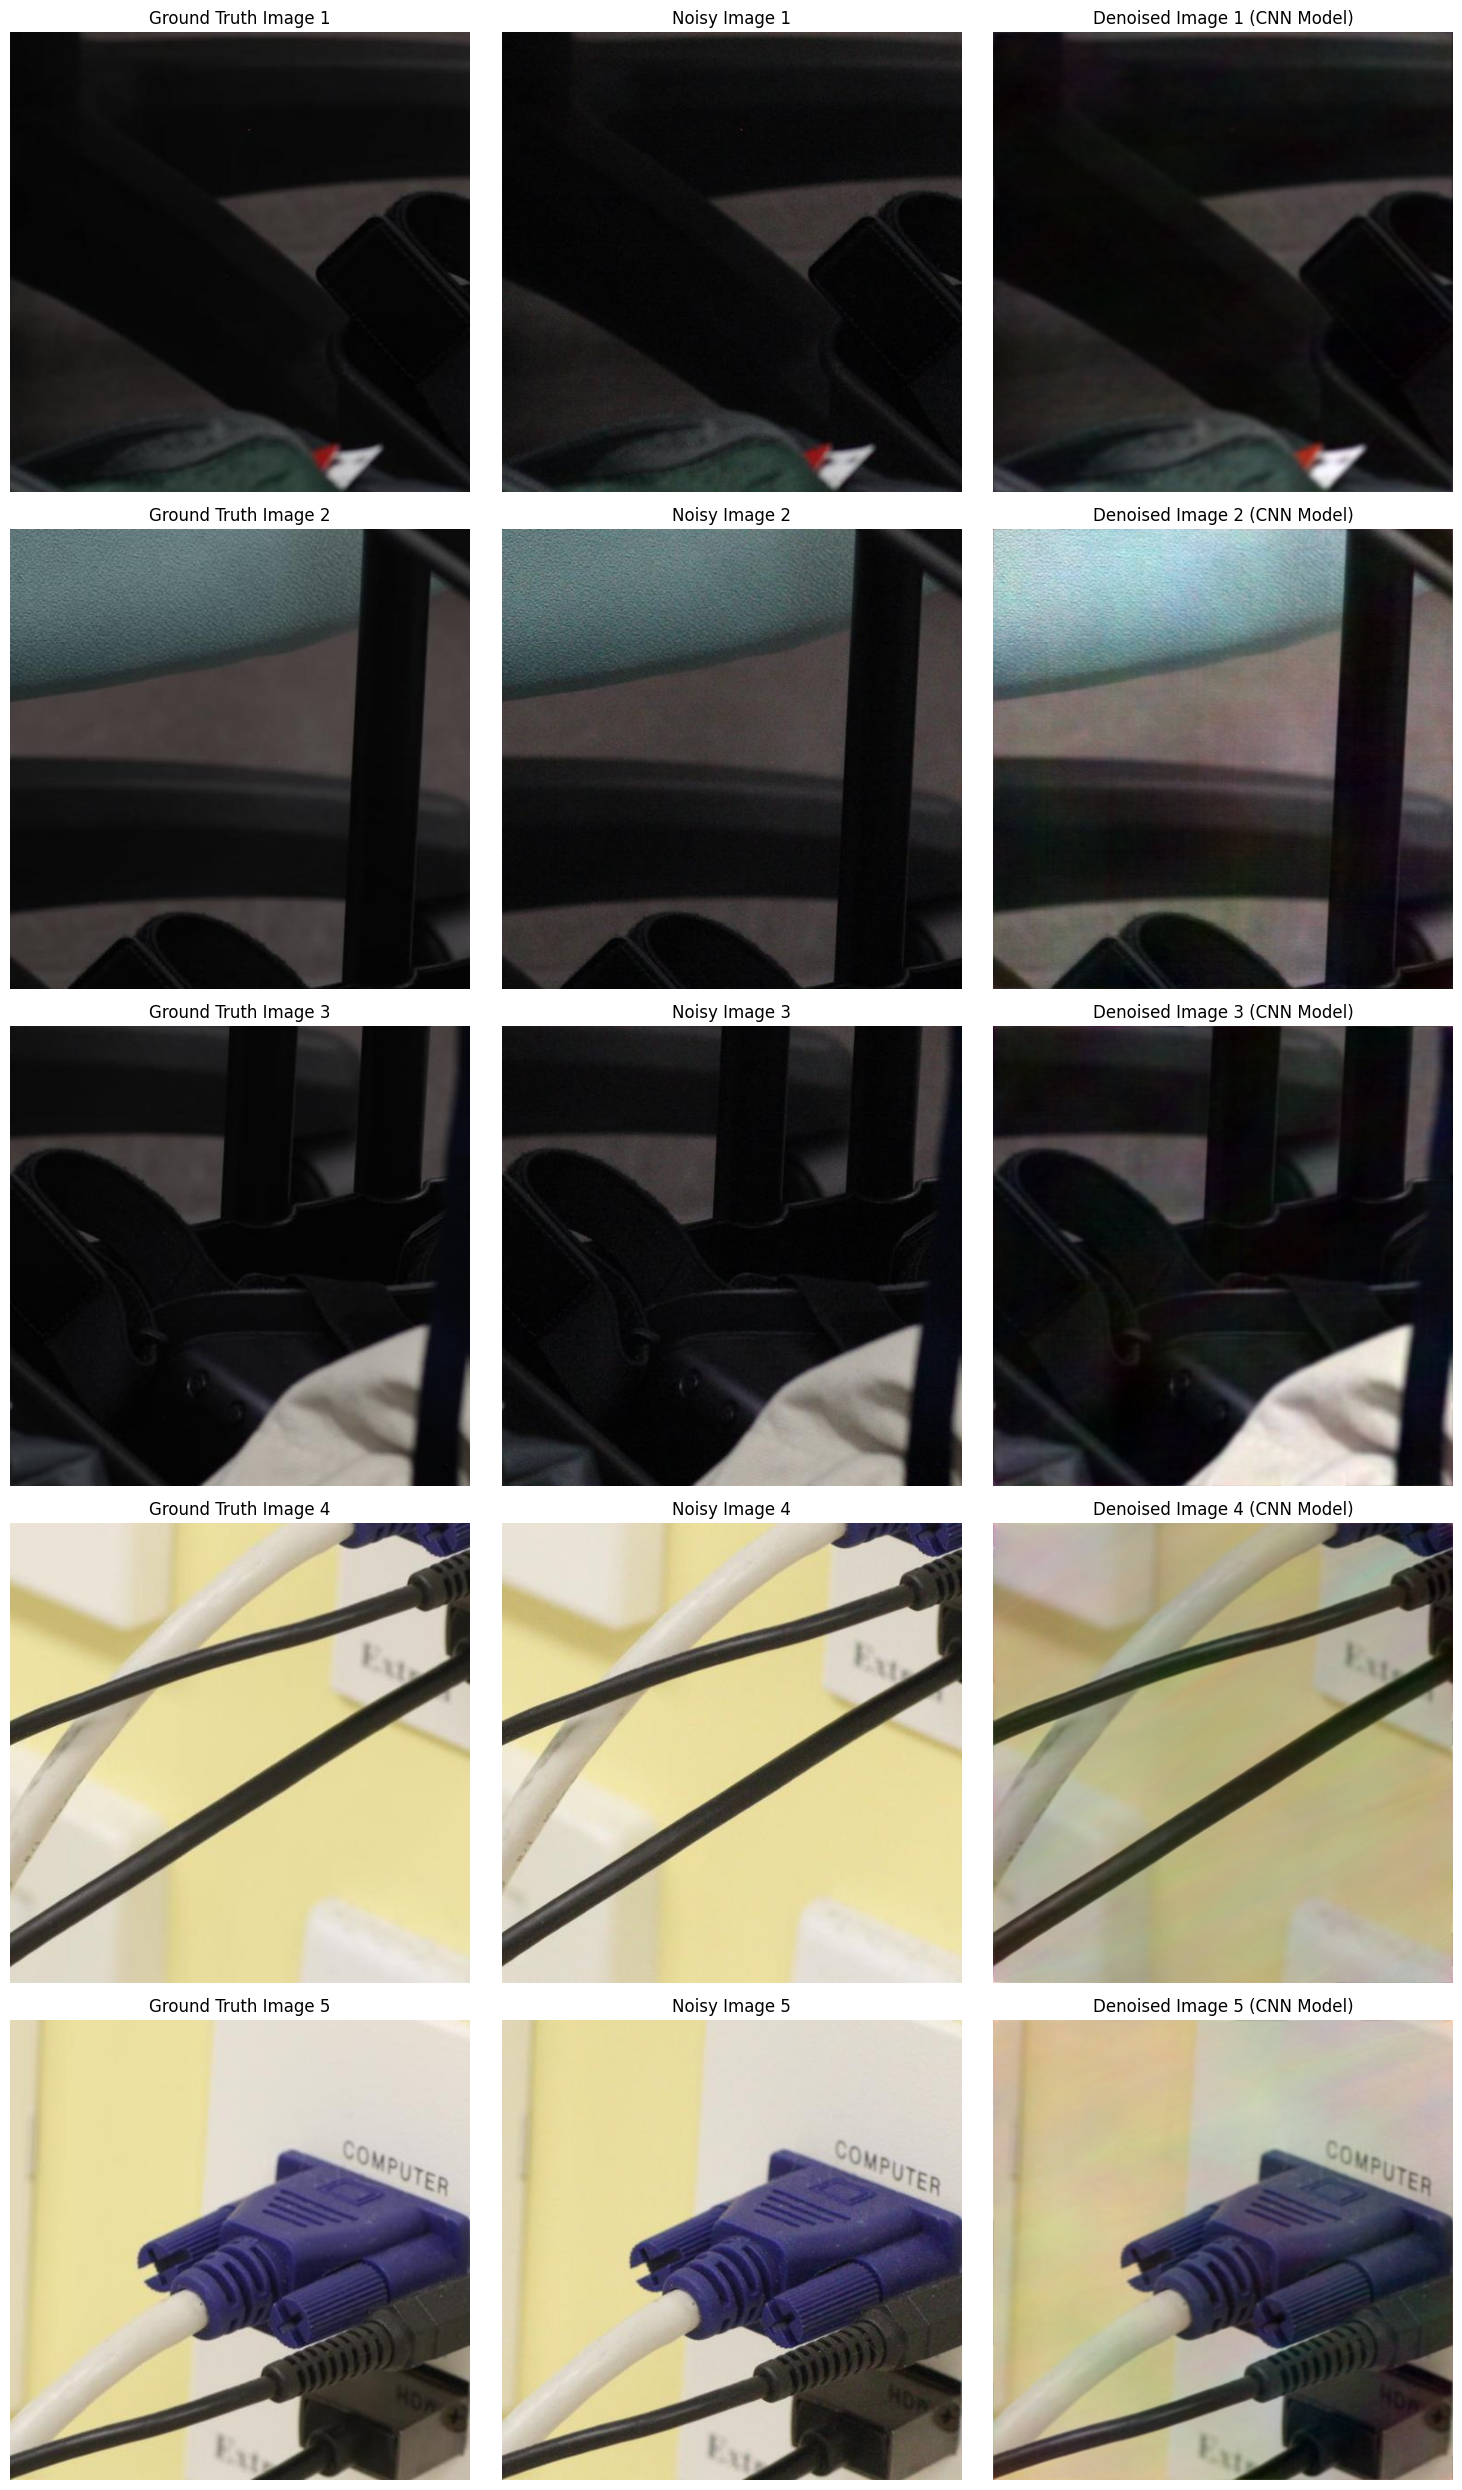

In [9]:
visualize_examples(image_examples,N=5)

# Calculate metrics and visualize a single input image pair

1/1 [==============================] - 1s 736ms/step
PSNR: 23.267127990722656
SSIM: 0.9027096629142761


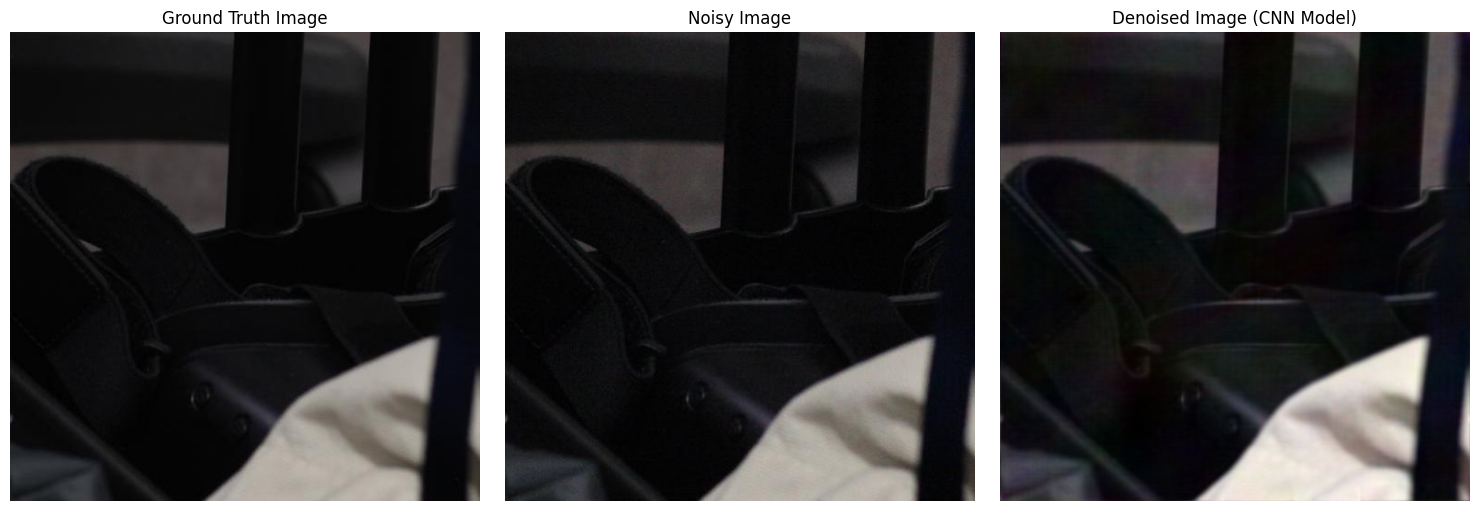

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def calculate_and_compare_single_image(real_path, mean_path, model):
    # Load and preprocess images
    noisy_img = load_img(real_path, target_size=(512, 512))  # Load original noisy image
    clean_img = load_img(mean_path, target_size=(512, 512))  # Load original clean image
    noisy_array = img_to_array(noisy_img) / 255.0
    clean_array = img_to_array(clean_img) / 255.0

    # Assume this returns Fourier transformed noisy image (real and imaginary parts interleaved)
    noisy_ft, _ = load_and_preprocess_image(real_path, mean_path)

    # Expand dimensions to simulate batch size of 1 for prediction
    noisy_ft = np.expand_dims(noisy_ft, axis=0)

    # Predict the denoised image in the Fourier domain
    predicted_clean_ft = model.predict(noisy_ft)[0]

    # Reconstruct the denoised image from its Fourier transform
    reconstructed_denoised = reconstruct_from_fourier(predicted_clean_ft)

    # Store example images for display
    examples = (clean_array, noisy_array, reconstructed_denoised)

    # Calculate PSNR and SSIM
    clean_array_tensor = tf.convert_to_tensor(clean_array, dtype=tf.float32)
    reconstructed_denoised_tensor = tf.convert_to_tensor(reconstructed_denoised, dtype=tf.float32)
    psnr_value = tf.image.psnr(clean_array_tensor, reconstructed_denoised_tensor, max_val=1.0).numpy()
    ssim_value = tf.image.ssim(clean_array_tensor, reconstructed_denoised_tensor, max_val=1.0).numpy()

    return psnr_value, ssim_value, examples


def visualize_single_example(clean_img, noisy_img, denoised_img):
    plt.figure(figsize=(15, 5))  # Set the figure size to accommodate three images side by side

    # Plotting the clean image
    plt.subplot(1, 3, 1)
    plt.imshow(clean_img)
    plt.title('Ground Truth Image')
    plt.axis('off')

    # Plotting the noisy image
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_img)
    plt.title('Noisy Image')
    plt.axis('off')

    # Plotting the denoised image
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_img)
    plt.title('Denoised Image (CNN Model)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


real_path = 'CroppedImages/Canon5D2_5_160_3200_chair_5_real.JPG'  # Noisy Image path, give the path of the image you want to denoise
mean_path = 'CroppedImages/Canon5D2_5_160_3200_chair_5_mean.JPG'  # Ground Truth Image path, give the path of the clean image



psnr_value, ssim_value, single_example = calculate_and_compare_single_image(real_path, mean_path, model)

print(f"PSNR: {psnr_value}")
print(f"SSIM: {ssim_value}")

visualize_single_example(*single_example)